In [1]:
#!/usr/bin/python
# updated DBR 02/2023 #

%matplotlib inline

import numpy as np
import scipy.optimize as opt
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#for mixed effects models
import statsmodels.api as sm
import statsmodels.formula.api as smf

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

import os

#my power law fitter, for smaller sample sizes
import ra_module

sns.set_style("ticks")

import warnings
warnings.filterwarnings(action='once')


In [2]:
#read output dataframe from make_dfs-TCR
outdf=pd.read_csv('data/clean/ecometrics_wprovirusrecalc.csv')


In [3]:
strict_only=False #for ag specific designation


In [4]:
#functions for distribution fitting

#ecology calculations from resampled list of abundances

def calc_ecol(rs):
    l=rs[rs>0] #just keep nonzero
    R=len(l);  
    r=np.arange(R)+1
    a=-np.sort(-l)
    N=np.sum(a)
    pars=a/N
    cpa=np.cumsum(pars)
    
    D1=np.exp(-np.sum(pars*np.log(pars))) 
    D2=1/np.sum(pars**2)
    
    maxclone=a[0]/N
    
    top10clones=np.sum(a[:10])/N
    
    clonalf=np.sum(a[a>1])/N
    
    return r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf

#single power law
def pwl1(xx):
    al1=xx
    model_pa= r**-al1
    return model_pa/np.sum(model_pa)

#2 phase power law
def pwl2(xx):    
    al1,al2,psi=xx
    model_pa= r**-al1 + 1/psi*r**-al2
    return model_pa/np.sum(model_pa)
        
#calculate error for distribution, species abundance distribution
def SAD_error(xx):
    
    if dist_name=='pwl1':
        model_pa=pwl1(xx)
        
    if dist_name=='pwl2':
        model_pa=pwl2(xx)
           
    RMS = np.sqrt(np.mean((cpa[:maxr]-np.cumsum(model_pa[:maxr]))**2))
    #KS = np.max(cpa[:maxr]-np.cumsum(model_pa[:maxr]))
    #error=RMS
    return RMS

#had ried other models in past... check older code

PWH 22 number AAs (CMV, HIV): 335 69
PWH 583 number AAs (CMV, HIV): 323 25


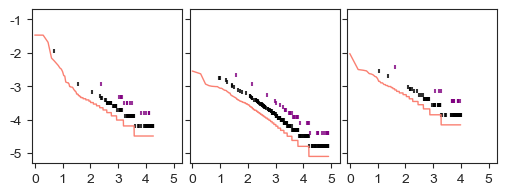

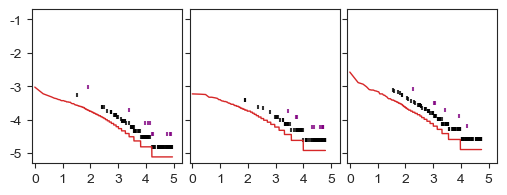

In [5]:
#plot rank abundances over time and annotate HIV and CMV

dfl=[[],[]] #list for dataframes by ppt and eventualy by tp
la=[]
lr=[]
Ntop=100 #top 10
for ippt,ppt in enumerate(['22','583']):

    CMVdf = pd.read_excel('data/raw/AgSpecificTCR/Pt'+ppt+'-CMV.xlsx')
    HIVdf = pd.read_excel('data/raw/AgSpecificTCR/Pt'+ppt+'-HIV.xlsx')
    
    #CMVcdf = pd.read_excel('data/raw/AgSpecificTCR/Pt'+ppt+'-control.xlsx',sheet_name='CMV')
    #HIVcdf = pd.read_excel('data/raw/AgSpecificTCR/Pt'+ppt+'-control.xlsx',sheet_name='HIV')

    control_df = pd.read_excel('data/raw/AgSpecificTCR/'+ppt+'_controls_removed_CMV_HIV.xlsx')
    
    #could restrict to strict... 'Strict or Loose or nonpos criteria'
    if strict_only:
        CMVdf=CMVdf[CMVdf['Strict or Loose or nonpos criteria']=='strict']
        HIVdf=HIVdf[HIVdf['Strict or Loose or nonpos criteria']=='strict']

    print('PWH',ppt,'number AAs (CMV, HIV):',len(CMVdf),len(HIVdf))#,len(CMVcdf),len(HIVcdf))

    fig,axs=plt.subplots(1,3,figsize=(6,2),sharex=True,sharey=True)
    pptcz=outdf[outdf['pid']=='PWH'+ppt+'_t0']['color'].iloc[0]

    sz=10
    alz=0.8
    upscl=2; upscl2=5 #how much above the curve to put the dots
    for tp in range(3):

        dfi = pd.read_csv('data/raw/TCR/PWH'+ppt+'_t'+str(tp)+'.tsv', sep='\t',
                    usecols=['extended_rearrangement','templates','frame_type','cdr3_amino_acid'],low_memory=False).dropna()
        
        dfi = dfi.sort_values(by=['templates'],ascending=False)
        dfi['tempr']=np.arange(len(dfi))+1
        dfi['pa']=dfi['templates']/np.sum(dfi['templates'])

        #now merge with virus specific lists
        CMVonly=pd.merge(dfi, CMVdf, how='inner', on=['cdr3_amino_acid']) #the intersection
        HIVonly=pd.merge(dfi, HIVdf, how='inner', on=['cdr3_amino_acid']) #the intersection

        #now merge with CONTROL specific lists
        #then, make sure to sample a random number of clones from the control (match Ag specific number)
        #CMVonlyC=dfi.sample(n=len(CMVonly)) #the intersection, keeping the old ranks
        #HIVonlyC=dfi.sample(n=len(HIVonly)) #the intersection

        CMVonlyC=pd.merge(dfi, control_df, how='inner', on=['cdr3_amino_acid']).sample(n=len(CMVonly)) #the intersection, keeping the old ranks
        HIVonlyC=pd.merge(dfi, control_df, how='inner', on=['cdr3_amino_acid']).sample(n=len(HIVonly)) #the intersection
    
        dfl[ippt].append([-np.sort(-CMVonly['pa'].values),
                          -np.sort(-HIVonly['pa'].values),
                          CMVonlyC['pa'].values,HIVonlyC['pa'].values])

        la.append([CMVonly['pa'].sum(),CMVonlyC['pa'].sum(), HIVonly['pa'].sum(), HIVonlyC['pa'].sum()])
        
        lr.append([len(CMVonly[CMVonly['tempr']<Ntop]),len(HIVonly[HIVonly['tempr']<Ntop])])

        ax=axs[tp]
        ax.loglog(dfi['tempr'],dfi['pa'],label='all TCR',color=pptcz,lw=1)
        ax.scatter(CMVonly['tempr'],CMVonly['pa']*upscl,marker='|',label='CMV specific, n='+str(len(CMVonly)),s=sz,alpha=alz,color='k')
        ax.scatter(HIVonly['tempr'],HIVonly['pa']*upscl2,marker='|',
                    label='HIV specific, n='+str(len(HIVonly)),s=sz,alpha=alz,color='purple')
        
    ax.set_xticks(np.logspace(0,5,6))
    ax.set_xticklabels(np.arange(0,6))
    ax.set_yticks(np.logspace(-5,0,6))
    ax.set_yticklabels(np.arange(-5,1))

    ax.set_xlim([0.8,2e5])
    ax.set_ylim([0.5e-5,0.2])

    plt.subplots_adjust(hspace=0.05,wspace=0.05)
    plt.savefig('figures/Pt'+ppt+'-rankabund2.svg',dpi=600,transparent=True)



In [6]:
#how often does CMV/HIV appear in the top N chosen above
lr

[[2, 0], [11, 1], [2, 1], [1, 1], [2, 0], [6, 0]]

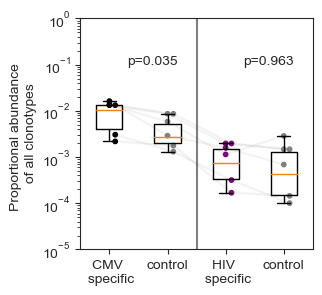

In [7]:
plt.figure(figsize=(3.,3))
jit=0.05
for ip in range(2):
    for tp in range(3):
        plt.scatter(np.arange(1,5)+ip/10,la[ip*2+tp],c=['black','gray','purple','gray',],s=10)
        plt.plot(np.arange(1,5)+ip/10,la[ip*2+tp],color='gray',alpha=0.1)
        #plt.scatter(np.arange(4)+np.random.normal(1,jit)+ip/10,la[ip*2+tp],c=['black','gray','tab:red','gray',])
plt.semilogy()

laa=np.array(la)
plt.boxplot([laa[:,0],laa[:,1],laa[:,2],laa[:,3]])

U,p=st.ttest_rel(laa[:,0],laa[:,1])
plt.annotate('p='+str(np.round(p,3)),[1.3,1e-1])

U,p=st.ttest_rel(laa[:,2],laa[:,3])
plt.annotate('p='+str(np.round(p,3)),[3.3,1e-1])

plt.ylabel('Proportional abundance \n of all clonotypes')
plt.ylim([1e-5,1])
plt.xticks([1,2,3,4],['CMV \n specific','control','HIV \n specific','control'])
plt.axvline(2.5,ls='-',color='k',alpha=0.5)
plt.savefig('figures/totalpropabund2.svg')


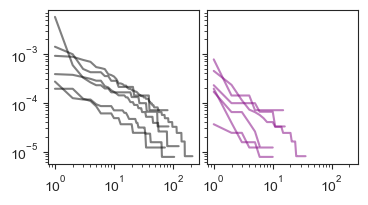

In [8]:
#make a rank abundance curve for JUST viral specific

alz=0.5
cz=['black','purple']
fig,axs=plt.subplots(1,2,figsize=(4,2),sharex=True,sharey=True)
for ip in range(2):
    for tp in range(3):

        for iV in range(2):
            pa = dfl[ip][tp][iV]
            axs[iV].plot(np.arange(len(pa))+1,pa,marker='',alpha=alz,color=cz[iV])

axs[0].loglog()
#axs[0].set_ylabel('Proportional abundance')
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.savefig('figures/virspecificrankabund2.svg')


In [9]:
#ecology on Ag specific, make ecol huge list

#compare with TCR and provirus ecology, but need to sample all the same...
pdf=pd.read_csv('data/clean/PWHproviral.csv') #proviral clones

fit_l=[]
vname=['CMV','HIV']

ecolml=[]; alml=[]; tl=[]; #big lists of outputs
ecolAgl=[]; ecolprol=[] #smaller easier ones for df for ag specific and proviruses

czl=['salmon','maroon']
#loop over ppts who had Ag
for ip,ppt in enumerate(['22','583']):

    cz=czl[ip]
    CMVdf = pd.read_excel('data/raw/AgSpecificTCR/Pt'+ppt+'-CMV.xlsx')
    HIVdf = pd.read_excel('data/raw/AgSpecificTCR/Pt'+ppt+'-HIV.xlsx')
    CMVcdf = pd.read_excel('data/raw/AgSpecificTCR/Pt'+ppt+'-control.xlsx',sheet_name='CMV')
    HIVcdf = pd.read_excel('data/raw/AgSpecificTCR/Pt'+ppt+'-control.xlsx',sheet_name='HIV')

    #could restrict to strict... 'Strict or Loose or nonpos criteria'
    strict_only=False
    if strict_only:
        CMVdf=CMVdf[CMVdf['Strict or Loose or nonpos criteria']=='strict']
        HIVdf=HIVdf[HIVdf['Strict or Loose or nonpos criteria']=='strict']

    #loop over time points
    for tp in [1,2]: #don't deal with t0 since no provirus to compare?

        pdfi = pdf[pdf['pidT']=='PWH'+ppt+'_t'+str(tp)]
        HIVsize=np.sum(pdfi['counts'])
        
        dfi = pd.read_csv('data/raw/TCR/PWH'+ppt+'_t'+str(tp)+'.tsv', sep='\t',
                    usecols=['extended_rearrangement','templates','frame_type','cdr3_amino_acid'],low_memory=False).dropna()

        #now merge with virus specific lists
        CMVonly=pd.merge(dfi, CMVdf, how='inner', on=['cdr3_amino_acid']) #the intersection
        HIVonly=pd.merge(dfi, HIVdf, how='inner', on=['cdr3_amino_acid']) #the intersection

        ti=outdf[outdf['pid']=='PWH'+ppt+'_t'+str(tp)]['mo_post_ART'].iloc[0]
        tl.append(ti) #month of sample
        
        #loop over HIV and CMV specific
        for iV,Vdf in enumerate([CMVonly,HIVonly]):
            r = np.arange(len(Vdf))+1
            a = -np.sort(-Vdf['templates'])
            pa= a/np.sum(a)
            VN=np.sum(Vdf['templates']); #sample size of virus specific

            #ACTUALLY, put them all at the SAME sample size, whatever is the lowest
            print(VN,HIVsize)
            if HIVsize<VN:
                rsH = np.random.multinomial(n=HIVsize,pvals=pa) #resampled abundance
                ppa = pdfi['counts'].values
                ppa = ppa[ppa>0] #abundances of provirus sequences
            else:
                rsH = a
                ppa = np.random.multinomial(n=VN,pvals=pdfi['counts'].values/HIVsize) #resampled abundance
                
            outHAg=calc_ecol(rsH) #ecology metrics for Ag specific at this smallest size
            outp=calc_ecol(ppa) #ecology metrics for HIV provirus at this smallest size
            ecolml.append([outHAg,outp]) 
            
            #get powerlaws from these downsampled datasets
            fit_al,fit_score,ll=ra_module.fit_pwl1(num_fits=30,num_replicates=3,dat_abund=rsH,R=10**6,max_al=2)
            best_alAg=fit_al[np.argmin(fit_score[0])]

            fit_al,fit_score,ll=ra_module.fit_pwl1(num_fits=30,num_replicates=3,dat_abund=rsH,R=10**6,max_al=2)
            best_alp=fit_al[np.argmin(fit_score[0])]

            alml.append([best_alAg,best_alp])
            
            #note calc_ecol outputs - r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf
            r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=outHAg
            N=np.sum(a)
            ecolAgl.append([ppt,ti,vname[iV],N,R/N,D1/N,D2/N,best_alAg])

            r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=outp
            N=np.sum(a)
            ecolprol.append([ppt,ti,vname[iV],N,R/N,D1/N,D2/N,best_alp])

df_ecolAg = pd.DataFrame(ecolAgl,columns=['ppt','mo','Ag','N','R','D1','D2','al'])


2027 48
198 48
189 41
28 41
181 54
14 54
568 58
29 58


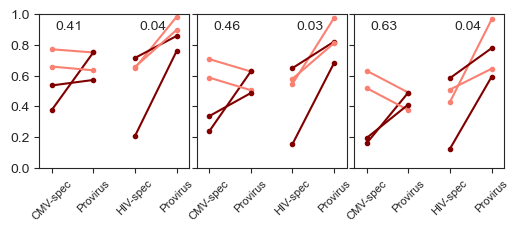

In [17]:
#plot ecology for Ag specific vs provirus at same sample size

fig,axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(6,2))

czl=['salmon','maroon']*4
Rll=[]; D1ll=[]; D2ll=[]
mz=['s','>']
#for participant
for j in range(len(ecolml)):
    Rl=[]; D1l=[]; D2l=[]
    #for time point
    for i in range(2):
        N=np.sum(ecolml[j][i][1])
        Rl.append(ecolml[j][i][4]/N)
        D1l.append(ecolml[j][i][5]/N)
        D2l.append(ecolml[j][i][6]/N)
        
        #plt.scatter(color=czl[j],marker=mz[i])

    jj=0;
    if j>3:
        jj=2
    axs[0].plot([1+jj,2+jj],Rl,marker='.',color=czl[j])
    axs[1].plot([1+jj,2+jj],D1l,marker='.',color=czl[j])
    axs[2].plot([1+jj,2+jj],D2l,marker='.',color=czl[j])
    
    Rll.append(Rl)
    D1ll.append(D1l)
    D2ll.append(D2l)
    
for ii in range(3):
    axs[ii].set_xticks([1,2,3,4])
    axs[ii].set_xticklabels(['CMV-spec','Provirus','HIV-spec','Provirus'],fontsize=8,rotation=45)
    
axs[0].set_xlim([0.7,4.3])
axs[0].set_ylim([0,1.])
    
#get pvals
for ill,ll in enumerate([Rll,D1ll,D2ll]):
    axs[ill].annotate(str(np.round(st.ttest_rel(np.array(ll[:4])[:,0],np.array(ll[:4])[:,1])[1],2)),[1.1,0.9],) #CMV vs provirus
    axs[ill].annotate(str(np.round(st.ttest_rel(np.array(ll[4:])[:,0],np.array(ll[4:])[:,1])[1],2)),[3.1,0.9],) #HIV vs provirus

#plt.legend()
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.savefig('figures/pairedAgvsprovirus.svg')


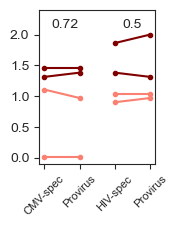

In [18]:
#plot power law fits for Ag specific vs provirus

plt.figure(figsize=(1.5,2))
czl=['salmon','maroon']*4
for j in range(len(alml)):
    jj=0;
    if j>3:
        jj=2
    plt.plot([1+jj,2+jj],alml[j],marker='.',color=czl[j])
    
plt.xticks([1,2,3,4],['CMV-spec','Provirus','HIV-spec','Provirus'],fontsize=8,rotation=45)


plt.annotate(str(np.round(st.ttest_rel(np.array(alml[:4])[:,0],np.array(alml[:4])[:,1])[1],2)),[1.2,2.1],) #CMV vs provirus
plt.annotate(str(np.round(st.ttest_rel(np.array(alml[4:])[:,0],np.array(alml[4:])[:,1])[1],2)),[3.2,2.1],) #HIV vs provirus
plt.ylim(-0.1,2.4)

plt.savefig('figures/pairedalphaAgvsprovirus.svg',dpi=600)



CMV p= 0.49052872484397136
CMV p= 0.649427909176935
CMV p= 0.8938260452860249
HIV p= 0.473187908110146
HIV p= 0.4331818081915728
HIV p= 0.40800757059272863


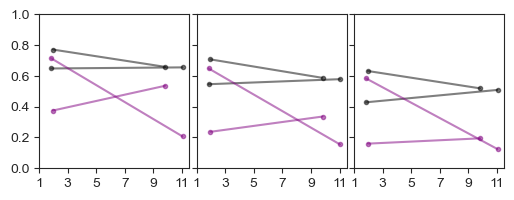

In [12]:
#plot ecology for Ag specific OVER TIME

czl=['black','purple']
fig,axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(6,2))
for iv,v in enumerate(vname):
    tdf = df_ecolAg[df_ecolAg['Ag']==v]

    for m in ['R','D1','D2']:
        print(v,'p=',st.pearsonr(tdf['mo'],tdf[m])[1])
    
    for ip,ppt in enumerate(['22','583']):
        tdf2 = tdf[tdf['ppt']==ppt]
        axs[0].plot(tdf2['mo']/12,tdf2['R'],color=czl[iv],marker='.',label=ppt,alpha=0.5)
        axs[1].plot(tdf2['mo']/12,tdf2['D1'],color=czl[iv],marker='.',alpha=0.5)
        axs[2].plot(tdf2['mo']/12,tdf2['D2'],color=czl[iv],marker='.',alpha=0.5)

axs[0].set_ylim([0,1])
axs[0].set_xticks(np.arange(1,12,2))
plt.subplots_adjust(wspace=0.05,hspace=0.1)
plt.savefig('figures/longit_Ag_diversity.svg')

CMV p= 0.48450627904807275
HIV p= 0.21350794179550903


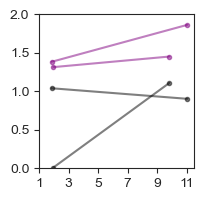

In [13]:
#plot ecology for Ag specific OVER TIME

czl=['black','purple']
fig,axs = plt.subplots(1,1,sharex=True,sharey=True,figsize=(2,2))
for iv,v in enumerate(vname):
    tdf = df_ecolAg[df_ecolAg['Ag']==v]

    print(v,'p=',st.pearsonr(tdf['mo'],tdf['al'])[1])
    
    for ip,ppt in enumerate(['22','583']):
        tdf2 = tdf[tdf['ppt']==ppt]
        axs.plot(tdf2['mo']/12,tdf2['al'],color=czl[iv],marker='.',label=ppt,alpha=0.5)

axs.set_ylim([0,2])
axs.set_xticks(np.arange(1,12,2))
plt.subplots_adjust(wspace=0.05,hspace=0.1)
plt.savefig('figures/longit_Ag_slope.svg')